## Importing all the libraries used in the notebook

In [1]:
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#!conda install -c anaconda xlrd --yes # to read excels

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [2]:
boston_data = pd.read_excel('boston_neighborhoods.xls')
boston_data

,Zip,Neighborhood,Latitude,Longitude
0,2108,Beacon Hill/Financial District,42.357903,-71.06408
1,2110,Financial District,42.356532,-71.05365
2,2111,Chinatown/Financial District/Leather District,42.349838,-71.06101
3,2113,North End,42.365028,-71.05636
4,2114,Beacon Hill/West End,42.361792,-71.06774
5,2115,Back Bay/Fenway–Kenmore,42.343080,-71.09268
6,2116,Back Bay/Bay Village,42.349622,-71.07372
7,2118,South End,42.338724,-71.07276
8,2119,Roxbury,42.324511,-71.08455
9,2120,Mission Hill,42.332099,-71.09651


In [3]:
print('The dataframe has {} neighborhoods.'.format(boston_data.shape[0]))

The dataframe has 29 neighborhoods.


## Using geopy library to get the latitude and longitude values of Boston
In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent bos_explorer, as shown below.

In [4]:
address = 'Boston, MA'

geolocator = Nominatim(user_agent="bos_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Boston are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Boston are 42.3602534, -71.0582912.


## Visualizing Boston and it's neighborhoods on a map.

In [5]:
# create map of Boston using latitude and longitude values
map_boston = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(boston_data['Latitude'], boston_data['Longitude'], boston_data['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_boston)  
    
map_boston

## Defining Foursquare Credentials and Version

In [6]:
import getpass

In [90]:
credential_id = getpass.getpass('Enter your credential ID')
credential_pass = getpass.getpass('Enter credential password')

Enter your credential ID········
Enter credential password········


In [91]:
CLIENT_ID = credential_id # your Foursquare ID
CLIENT_SECRET = credential_pass # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

## Exploration of Boston downtown

Getting coordinates of Financial District

In [21]:
neighborhood_latitude = boston_data.loc[1, 'Latitude'] 
neighborhood_longitude = boston_data.loc[1, 'Longitude']

neighborhood_name = boston_data.loc[1, 'Neighborhood']

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Financial District are 42.356532, -71.05365.


## Using Foursquare API to fetch near by venues and points of interest.


First, a function to extracting the categories

In [22]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Creating URL for the api to fetch nearby venues.

In [23]:
# Setting Radius to 1000m so that entire Downtown could be covered
radius = 1000
LIMIT = 100

offset = 0
total_venues = 0

# Creating empty Dataframe
foursquare_venues = pd.DataFrame(columns = ['id','name', 'categories', 'lat', 'lng'])

# Creating the URL 
while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
          '&client_secret={}&ll={},{}&v={}&radius={}&limit={}&offset={}').format(CLIENT_ID,
                                                                  CLIENT_SECRET,
                                                                  neighborhood_latitude,
                                                                  neighborhood_longitude,
                                                                  VERSION,
                                                                  radius,
                                                                  LIMIT,
                                                                  offset)
    result = requests.get(url).json()
    
    # Extracting data from JSON
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} m".format(venues_fetched, radius))
    
    venues = result['response']['groups'][0]['items']
    nearby_venues = json_normalize(venues)
    
    # Filter the columns
    filtered_columns = ['venue.id','venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues = nearby_venues.loc[:, filtered_columns]

    # Filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis = 1)

    # Clean all column names
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, nearby_venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

Total 100 venues fetched within a total radius of 1000 m
Total 100 venues fetched within a total radius of 1000 m
Total 33 venues fetched within a total radius of 1000 m


## Building final dataframe from the JSON object

In [24]:
foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

foursquare_venues


Total 233 venues fetched


,id,name,categories,lat,lng
0,5b05fb67f193c0002cbd9455,Trillium Garden On The Greenway,Beer Garden,42.356540,-71.051100
1,55098425498e04ef460a3649,Kane's Donuts,Donut Shop,42.356209,-71.052895
2,4a8e279ff964a5201f1220e3,The Rose Kennedy Greenway,Park,42.358227,-71.052055
3,4a9699adf964a5205e2620e3,James Hook & Company,Seafood Restaurant,42.354960,-71.050911
4,4ac0e091f964a520d29420e3,Post Office Square,Park,42.356340,-71.055686
5,4d1a255481cea35d5867faec,Casa Razdora,Italian Restaurant,42.358231,-71.054741
6,4aca46bbf964a5202ec120e3,Equinox Franklin Street,Gym,42.356074,-71.054484
7,4a8407f5f964a520b4fb1fe3,The Langham Boston Hotel,Hotel,42.356482,-71.054501
8,4a79ae84f964a52054e71fe3,Boston Harbor Hotel,Hotel,42.356192,-71.050370
9,4bc791c692b376b041fa4f3a,One International Place,Office,42.355918,-71.052293


In [25]:
foursquare_venues['categories'].value_counts()

Italian Restaurant               27
Seafood Restaurant               14
Coffee Shop                      12
Bakery                           10
Hotel                             9
Historic Site                     8
Park                              8
American Restaurant               5
Pizza Place                       5
Bar                               5
Sandwich Place                    5
Salad Place                       4
Chinese Restaurant                4
Café                              4
New American Restaurant           4
Asian Restaurant                  4
Gym                               3
Vegetarian / Vegan Restaurant     3
Gym / Fitness Center              3
Market                            3
French Restaurant                 3
Sushi Restaurant                  3
Restaurant                        3
Tea Room                          3
Aquarium                          3
Beer Garden                       2
Mexican Restaurant                2
Deli / Bodega               

## Dropping unwanted categories

Since the foursquare API fetched all the nearby venues and we are interested just in food, we will get rid of unwanted categories by dropping them.

In [26]:
filtered_categories = foursquare_venues[~foursquare_venues['categories'].isin(['Park','Gym','Office','Historic Site','Monument / Landmark','Boxing Gym','Aquarium','Record Shop','Art Museum','Boat or Ferry',
                                                              'Tourist Information Center','Sculpture Garden','Gym / Fitness Center','History Museum','Market','Clothing Store','Library','Circus',
                                                              'Bookstore','Movie Theater','Opera House','Yoga Studio','Athletics & Sports','Convenience Store','Salon / Barbershop','Pharmacy',
                                                              'Scenic Lookout','Ski Chalet','Lake','Theater','Fish Market','Cycle Studio'])]
filtered_categories

,id,name,categories,lat,lng
0,5b05fb67f193c0002cbd9455,Trillium Garden On The Greenway,Beer Garden,42.356540,-71.051100
1,55098425498e04ef460a3649,Kane's Donuts,Donut Shop,42.356209,-71.052895
3,4a9699adf964a5205e2620e3,James Hook & Company,Seafood Restaurant,42.354960,-71.050911
5,4d1a255481cea35d5867faec,Casa Razdora,Italian Restaurant,42.358231,-71.054741
7,4a8407f5f964a520b4fb1fe3,The Langham Boston Hotel,Hotel,42.356482,-71.054501
8,4a79ae84f964a52054e71fe3,Boston Harbor Hotel,Hotel,42.356192,-71.050370
10,4bd1ddb677b29c74906f8d82,Mr. Dooley's,Pub,42.357783,-71.053553
11,539839c5498e6ed2a0935358,Wheelhouse,Burger Joint,42.358028,-71.053979
12,4bb25ed442959c7450be202c,Boston Wine Exchange,Wine Shop,42.356070,-71.057420
13,4f049c5d00399761c77a111b,Zo,Greek Restaurant,42.359196,-71.055467


## Final dataframe with venue coordinates

In [50]:
df_downtown = filtered_categories.reset_index(drop=True)
df_downtown

,id,name,categories,lat,lng
0,5b05fb67f193c0002cbd9455,Trillium Garden On The Greenway,Beer Garden,42.356540,-71.051100
1,55098425498e04ef460a3649,Kane's Donuts,Donut Shop,42.356209,-71.052895
2,4a9699adf964a5205e2620e3,James Hook & Company,Seafood Restaurant,42.354960,-71.050911
3,4d1a255481cea35d5867faec,Casa Razdora,Italian Restaurant,42.358231,-71.054741
4,4a8407f5f964a520b4fb1fe3,The Langham Boston Hotel,Hotel,42.356482,-71.054501
5,4a79ae84f964a52054e71fe3,Boston Harbor Hotel,Hotel,42.356192,-71.050370
6,4bd1ddb677b29c74906f8d82,Mr. Dooley's,Pub,42.357783,-71.053553
7,539839c5498e6ed2a0935358,Wheelhouse,Burger Joint,42.358028,-71.053979
8,4bb25ed442959c7450be202c,Boston Wine Exchange,Wine Shop,42.356070,-71.057420
9,4f049c5d00399761c77a111b,Zo,Greek Restaurant,42.359196,-71.055467


In [28]:
print('There are {} places in Boston Downtown serving food.'.format(df_downtown['name'].count()))

There are 175 places in Boston Downtown serving food.


## Fetching restaurant details

To fetch restaurant details, Premium API calls have to be made to the Foursquare API. Since just 50 calls are allowed in a day, It took me multiple days to fetch details about all 175 restaurants. 

In [123]:
# breaking the dataframe into groups of 50 to make Premium calls
filtered_downtown = df_downtown[0:50]
filtered_downtown.head()

,id,name,categories,lat,lng
0,5b05fb67f193c0002cbd9455,Trillium Garden On The Greenway,Beer Garden,42.356540,-71.051100
1,55098425498e04ef460a3649,Kane's Donuts,Donut Shop,42.356209,-71.052895
2,4a9699adf964a5205e2620e3,James Hook & Company,Seafood Restaurant,42.354960,-71.050911
3,4d1a255481cea35d5867faec,Casa Razdora,Italian Restaurant,42.358231,-71.054741
4,4a8407f5f964a520b4fb1fe3,The Langham Boston Hotel,Hotel,42.356482,-71.054501


Extracting 'id' to pass to the function below

In [124]:
filtered_downtown2 = filtered_downtown['id']
filtered_downtown2.head()

0    5b05fb67f193c0002cbd9455
1    55098425498e04ef460a3649
2    4a9699adf964a5205e2620e3
3    4d1a255481cea35d5867faec
4    4a8407f5f964a520b4fb1fe3
Name: id, dtype: object

## Passing all the restaurants id's to the function to fetch the details.

In [92]:
url_base = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v=20180605'

venue_details2 =[]

for idee in filtered_downtown2:
    url22 = url_base.format(idee,CLIENT_ID,CLIENT_SECRET)
    results2 = requests.get(url22).json()
    venue_data2 =results2['response']['venue']
    
    try:
        venue_id2 =venue_data2['id']
        venue_name2=venue_data2['name']
        venue_likes2=venue_data2['likes']['count']
        venue_rating2=venue_data2['rating']
        venue_tips2=venue_data2['tips']['count']
        venue_details2.append([venue_id2,venue_name2,venue_likes2,venue_rating2,venue_tips2])
    except KeyError:
        pass

column_names2=['id','Name','Likes','Rating','Tips']
df1400 = pd.DataFrame(venue_details2,columns=column_names2)
df1400

522d039611d2b014b87950cf
534c8689498e86384e21ee16
573db5d2498e2903b5f5d138
40b28c80f964a520d7f71ee3
4aeb408ef964a52023c021e3
4b466becf964a520612026e3
5932f058123a1963f5d985b8
4a74a6a2f964a5200bdf1fe3
53c1bcdb498e0567f9c29514
50f9605952626efd899f60e0
3fd66200f964a52096ec1ee3
4a5a8f01f964a52090ba1fe3
4ada50baf964a520442121e3
533af1e0498ef6b88ba46b50
5b969de351950e002c1ff3d5
55e0c3d7498ec10bc1501534
58a36ab55490d37d6129f217
4a5a9d17f964a520a6ba1fe3
45016cecf964a520c2381fe3
4fde3cebe4b052337467341d
4885ecf8f964a52040511fe3
532b33a8498ef1accc370173
4b11cf55f964a520278523e3
4b60d993f964a5208dfd29e3
56b54b5438faaafbab659f33
4bd0a43acaff9521813ecff0
5805180138fad92a6f379e9b
58503e9c6cea3f5efb665284
5a13605ee96d0c3ed5b426d8
51a49c41498e034cea66e562
4aa2e6e4f964a520924220e3
4a4b7a0df964a52067ac1fe3
4c91546ab641236ab6a68079
4ace9d7ff964a52072d120e3
594036b7f193c07478f13117


,id,Name,Likes,Rating,Tips
0,522d039611d2b014b87950cf,Locale,64,9.2,16
1,534c8689498e86384e21ee16,Parla,45,8.1,23
2,573db5d2498e2903b5f5d138,Caffè Nero,72,8.4,7
3,40b28c80f964a520d7f71ee3,Prezza,82,8.7,33
4,4aeb408ef964a52023c021e3,Al Dente,107,8.4,50
5,4b466becf964a520612026e3,The Daily Catch,125,8.4,89
6,5932f058123a1963f5d985b8,North Square Oyster,18,8.2,5
7,4a74a6a2f964a5200bdf1fe3,Taiwan Cafe,172,8.1,86
8,53c1bcdb498e0567f9c29514,Crave - Mad for Chicken,83,8.5,21
9,50f9605952626efd899f60e0,Bastille Kitchen,113,8.2,18


Ran the above cell multiple times, creating mini-dataframes in sequence with different restaurants.

In [66]:
df05

,id,Name,Likes,Rating,Tips
0,5b05fb67f193c0002cbd9455,Trillium Garden On The Greenway,91,9.4,4
1,55098425498e04ef460a3649,Kane's Donuts,83,9.1,14
2,4a9699adf964a5205e2620e3,James Hook & Company,324,9.1,87
3,4d1a255481cea35d5867faec,Casa Razdora,53,8.6,28
4,4a8407f5f964a520b4fb1fe3,The Langham Boston Hotel,141,8.4,52


In [125]:
df540 = df2 
df540.columns = ['id','Name','Likes','Rating','Tips']
df540.head()

,id,Name,Likes,Rating,Tips
0,4a79ae84f964a52054e71fe3,Boston Harbor Hotel,156,8.7,34
1,4bd1ddb677b29c74906f8d82,Mr. Dooley's,159,8.3,60
2,539839c5498e6ed2a0935358,Wheelhouse,49,8.3,22
3,4bb25ed442959c7450be202c,Boston Wine Exchange,32,8.7,9
4,4f049c5d00399761c77a111b,Zo,48,8.8,21


In [70]:
df4045

,id,Name,Likes,Rating,Tips
0,5045032ce4b0d8c7e03461c2,Abigail's Tea Room,25,8.6,8
1,580fff4938facc4e70a30904,Pabu Boston,54,8.5,10
2,4ad62461f964a520530521e3,Archie's New York Deli,45,8.6,18
3,525da4dd498eb92d634abc6f,Ruth's Chris Steak House,154,8.6,45
4,5447ad3b498ec638a88d77cf,"The Envoy Hotel, Autograph Collection",121,8.9,12


In [77]:
df4550

,id,Name,Likes,Rating,Tips
0,4bc510d422c676b0c89096d3,Boston Chowda Company,132,8.2,61
1,56af7b5b498e9db1d9234e39,Clover Food Lab DTX,75,8.4,20
2,504e504ce4b0be6c61455a6a,Falafel King,80,8.1,27
3,4ae61682f964a520a1a421e3,Boston Marriott Long Wharf,143,8.3,56
4,531380ba498ebbd592d9ea8c,The Merchant Kitchen & Drinks,141,8.1,30


In [126]:
df5095.head()

,id,Name,Likes,Rating,Tips
0,4bf18c843506ef3bea63bd22,Saus Restaurant,368,8.9,132
1,4a354728f964a520b69c1fe3,Boston Children's Museum,290,9.0,61
2,5ada1f45d807ee19fc27d98a,Spyce,33,8.1,9
3,4a367d22f964a5209f9d1fe3,Chacarero,115,8.2,39
4,53a84f07498e1d8dd81d22d4,Bonapita,29,8.1,8


In [127]:
df95140.head()

,id,Name,Likes,Rating,Tips
0,52f9083f498eb590de3e05f4,Tenoch,122,8.8,42
1,4dea5487d164ef597ce79171,Pauli's,107,8.8,52
2,50afd866e4b004e6d251ea84,Little Italy,54,8.9,4
3,55771dd2498ee58e1190b2d4,Committee,186,8.4,27
4,49c01e77f964a5204a551fe3,Drink,526,8.8,238


In [128]:
df1400.head()

,id,Name,Likes,Rating,Tips
0,522d039611d2b014b87950cf,Locale,64,9.2,16
1,534c8689498e86384e21ee16,Parla,45,8.1,23
2,573db5d2498e2903b5f5d138,Caffè Nero,72,8.4,7
3,40b28c80f964a520d7f71ee3,Prezza,82,8.7,33
4,4aeb408ef964a52023c021e3,Al Dente,107,8.4,50


## Concatinating the above created dataframes thus creating final details dataframe

In [109]:
restaurent_details = pd.concat([df05, df540, df4045, df4550, df5095, df95140, df1400], sort=False, ignore_index=True)

In [129]:
print(restaurent_details.count())
restaurent_details.head()

id        175
Name      175
Likes     175
Rating    175
Tips      175
dtype: int64


,id,Name,Likes,Rating,Tips
0,5b05fb67f193c0002cbd9455,Trillium Garden On The Greenway,91,9.4,4
1,55098425498e04ef460a3649,Kane's Donuts,83,9.1,14
2,4a9699adf964a5205e2620e3,James Hook & Company,324,9.1,87
3,4d1a255481cea35d5867faec,Casa Razdora,53,8.6,28
4,4a8407f5f964a520b4fb1fe3,The Langham Boston Hotel,141,8.4,52


In [119]:
#saving dataframe locally as a backup just incase if I delete or edit it
restaurent_details.to_csv(r'/Users/scarstruck/Desktop/restdetails.csv')

## Merging the Restaurants Details with Venue location dataframe 

In [112]:
df_left = pd.merge(df_downtown, restaurent_details, on='id', how='left')

In [113]:
df_left

,id,name,categories,lat,lng,Name,Likes,Rating,Tips
0,5b05fb67f193c0002cbd9455,Trillium Garden On The Greenway,Beer Garden,42.356540,-71.051100,Trillium Garden On The Greenway,91,9.4,4
1,55098425498e04ef460a3649,Kane's Donuts,Donut Shop,42.356209,-71.052895,Kane's Donuts,83,9.1,14
2,4a9699adf964a5205e2620e3,James Hook & Company,Seafood Restaurant,42.354960,-71.050911,James Hook & Company,324,9.1,87
3,4d1a255481cea35d5867faec,Casa Razdora,Italian Restaurant,42.358231,-71.054741,Casa Razdora,53,8.6,28
4,4a8407f5f964a520b4fb1fe3,The Langham Boston Hotel,Hotel,42.356482,-71.054501,The Langham Boston Hotel,141,8.4,52
5,4a79ae84f964a52054e71fe3,Boston Harbor Hotel,Hotel,42.356192,-71.050370,Boston Harbor Hotel,156,8.7,34
6,4bd1ddb677b29c74906f8d82,Mr. Dooley's,Pub,42.357783,-71.053553,Mr. Dooley's,159,8.3,60
7,539839c5498e6ed2a0935358,Wheelhouse,Burger Joint,42.358028,-71.053979,Wheelhouse,49,8.3,22
8,4bb25ed442959c7450be202c,Boston Wine Exchange,Wine Shop,42.356070,-71.057420,Boston Wine Exchange,32,8.7,9
9,4f049c5d00399761c77a111b,Zo,Greek Restaurant,42.359196,-71.055467,Zo,48,8.8,21


In [148]:
final_df = df_left.drop('Name', axis=1)

## The final is dataframe is ready


In [115]:
final_df

,id,name,categories,lat,lng,Likes,Rating,Tips
0,5b05fb67f193c0002cbd9455,Trillium Garden On The Greenway,Beer Garden,42.356540,-71.051100,91,9.4,4
1,55098425498e04ef460a3649,Kane's Donuts,Donut Shop,42.356209,-71.052895,83,9.1,14
2,4a9699adf964a5205e2620e3,James Hook & Company,Seafood Restaurant,42.354960,-71.050911,324,9.1,87
3,4d1a255481cea35d5867faec,Casa Razdora,Italian Restaurant,42.358231,-71.054741,53,8.6,28
4,4a8407f5f964a520b4fb1fe3,The Langham Boston Hotel,Hotel,42.356482,-71.054501,141,8.4,52
5,4a79ae84f964a52054e71fe3,Boston Harbor Hotel,Hotel,42.356192,-71.050370,156,8.7,34
6,4bd1ddb677b29c74906f8d82,Mr. Dooley's,Pub,42.357783,-71.053553,159,8.3,60
7,539839c5498e6ed2a0935358,Wheelhouse,Burger Joint,42.358028,-71.053979,49,8.3,22
8,4bb25ed442959c7450be202c,Boston Wine Exchange,Wine Shop,42.356070,-71.057420,32,8.7,9
9,4f049c5d00399761c77a111b,Zo,Greek Restaurant,42.359196,-71.055467,48,8.8,21


In [118]:
#saving dataframe locally as a backup just incase if I delete or edit it
final_df.to_csv(r'/Users/scarstruck/Desktop/restdetails.csv')

In [143]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175 entries, 0 to 174
Data columns (total 8 columns):
id            175 non-null object
name          175 non-null object
categories    175 non-null object
lat           175 non-null float64
lng           175 non-null float64
Likes         175 non-null int64
Rating        175 non-null float64
Tips          175 non-null int64
dtypes: float64(3), int64(2), object(3)
memory usage: 12.3+ KB


The dataframe looks ready to be used!

## Analysis

In [142]:
final_df.describe()

,lat,lng,Likes,Rating,Tips
count,175.000000,175.000000,175.000000,175.000000,175.000000
mean,42.357486,-71.055312,133.982857,8.476000,47.817143
std,0.004764,0.004730,169.047483,0.327646,65.463430
min,42.349541,-71.064724,0.000000,8.000000,0.000000
25%,42.353283,-71.058792,42.000000,8.200000,11.000000
50%,42.357574,-71.055069,86.000000,8.400000,27.000000
75%,42.361911,-71.052640,155.000000,8.700000,59.000000
max,42.365194,-71.043246,1512.000000,9.400000,568.000000


Giving a quick look to the dataframe's feautures, we can note that:

-  **Minimum rating for any restaurant is 8.0! That's too good!**
-  **Average rating for restaurants is 8.4.** 

In [144]:
final_df.iloc[final_df['Likes'].idxmax()]

id            4a1b3febf964a520dd7a1fe3
name                     Mike's Pastry
categories                 Pastry Shop
lat                            42.3642
lng                           -71.0541
Likes                             1512
Rating                             8.6
Tips                               568
Name: 127, dtype: object

In [146]:
final_df.iloc[final_df['Tips'].idxmax()]

id            4a1b3febf964a520dd7a1fe3
name                     Mike's Pastry
categories                 Pastry Shop
lat                            42.3642
lng                           -71.0541
Likes                             1512
Rating                             8.6
Tips                               568
Name: 127, dtype: object

**Looks like Mike's Pastry is the most liked food joint in the Downtown with the most number of Tips as well! This place definitely becomes the must visit venue.**

In [145]:
final_df.iloc[final_df['Rating'].idxmax()]

id                   5b05fb67f193c0002cbd9455
name          Trillium Garden On The Greenway
categories                        Beer Garden
lat                                   42.3565
lng                                  -71.0511
Likes                                      91
Rating                                    9.4
Tips                                        4
Name: 0, dtype: object

**Trillium Garden On The Greenway has got the best Ratings of all the restaurants.**

## Visualizing the food serving venues on the map

In [161]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=14) # generate map centred around the Boston Downtown

# add the restaurants as blue circle markers
for lat, lng, label in zip(final_df.lat, final_df.lng, final_df.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

Let's take a look at all the places having ratings more than 9.0

In [150]:
top_venues=final_df[final_df['Rating']>=9.0]

In [162]:
top_venues.head()

,id,name,categories,lat,lng,Likes,Rating,Tips
0,5b05fb67f193c0002cbd9455,Trillium Garden On The Greenway,Beer Garden,42.356540,-71.051100,91,9.4,4
1,55098425498e04ef460a3649,Kane's Donuts,Donut Shop,42.356209,-71.052895,83,9.1,14
2,4a9699adf964a5205e2620e3,James Hook & Company,Seafood Restaurant,42.354960,-71.050911,324,9.1,87
11,577be842498e0a21aa1cc211,Clover Food Lab FIN,Vegetarian / Vegan Restaurant,42.353715,-71.056216,62,9.1,10
26,545e63ab498ed5438af2a15e,Ghirardelli,Chocolate Shop,42.360412,-71.055324,48,9.0,7


In [177]:
top_venues_map = folium.Map(location=[latitude, longitude], zoom_start=14) # generate map centred around the Boston Downtown

# add the restaurants as blue circle markers
for lat, lng, label in zip(top_venues.lat, top_venues.lng, top_venues.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(top_venues_map)

# display map
top_venues_map

**From the map, we can see that highly rated restaurants are kind of evenly spread out throughout the downtown. So if you are hungry, you can get one of the best foods in the city within a 10 mins walk!**

In [180]:
fav_venues=final_df[final_df['Likes']>=300]

In [181]:
fav_venues

,id,name,categories,lat,lng,Likes,Rating,Tips
2,4a9699adf964a5205e2620e3,James Hook & Company,Seafood Restaurant,42.354960,-71.050911,324,9.1,87
32,4a7654cbf964a520d8e21fe3,Legal Sea Foods,Seafood Restaurant,42.359411,-71.050847,483,8.5,148
35,40b28c80f964a5209ff71ee3,Black Rose,Irish Pub,42.359310,-71.053593,332,8.1,112
50,4bf18c843506ef3bea63bd22,Saus Restaurant,Belgian Restaurant,42.361076,-71.057054,368,8.9,132
57,560d8c06498e79986a22ca43,Yvonne's,New American Restaurant,42.355664,-71.061466,327,9.2,70
58,40b28c80f964a52070f81ee3,The Barking Crab,Seafood Restaurant,42.353667,-71.048658,532,8.3,174
73,4b031148f964a5206b4c22e3,Flour Bakery & Cafe,Bakery,42.351266,-71.048830,495,9.0,182
86,50c61b1ae4b0bd0f65b00b19,Thinking Cup,Coffee Shop,42.363221,-71.055124,401,8.8,113
87,4ac53112f964a520dbb020e3,Neptune Oyster,Seafood Restaurant,42.363237,-71.056139,639,9.0,350
92,53734d5e498ef0e9f93925f3,Caffè Nero,Coffee Shop,42.353521,-71.062348,362,8.9,90


In [182]:
fav_venues_map = folium.Map(location=[latitude, longitude], zoom_start=14) # generate map centred around the Boston Downtown

# add the restaurants as blue circle markers
for lat, lng, label in zip(fav_venues.lat, fav_venues.lng, fav_venues.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(fav_venues_map)

# display map
fav_venues_map

**Some of the top liked places are mostly either in the northern half of the downtown i.e. near North End and there are fews places near Chinatown along with Seaport.**

In [183]:
fav_venues['categories'].value_counts()

Seafood Restaurant         6
Coffee Shop                3
Bakery                     2
Cocktail Bar               1
New American Restaurant    1
Gastropub                  1
Belgian Restaurant         1
Chinese Restaurant         1
Pastry Shop                1
Irish Pub                  1
American Restaurant        1
Name: categories, dtype: int64

**Also, 30% of the most liked venues are Seafood Restaurants!**

In [130]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

In [185]:
final_df['categories'].value_counts().head()

Italian Restaurant    27
Seafood Restaurant    14
Coffee Shop           12
Bakery                10
Hotel                  9
Name: categories, dtype: int64

## Exploring the different categories of restaurants.

<BarContainer object of 57 artists>

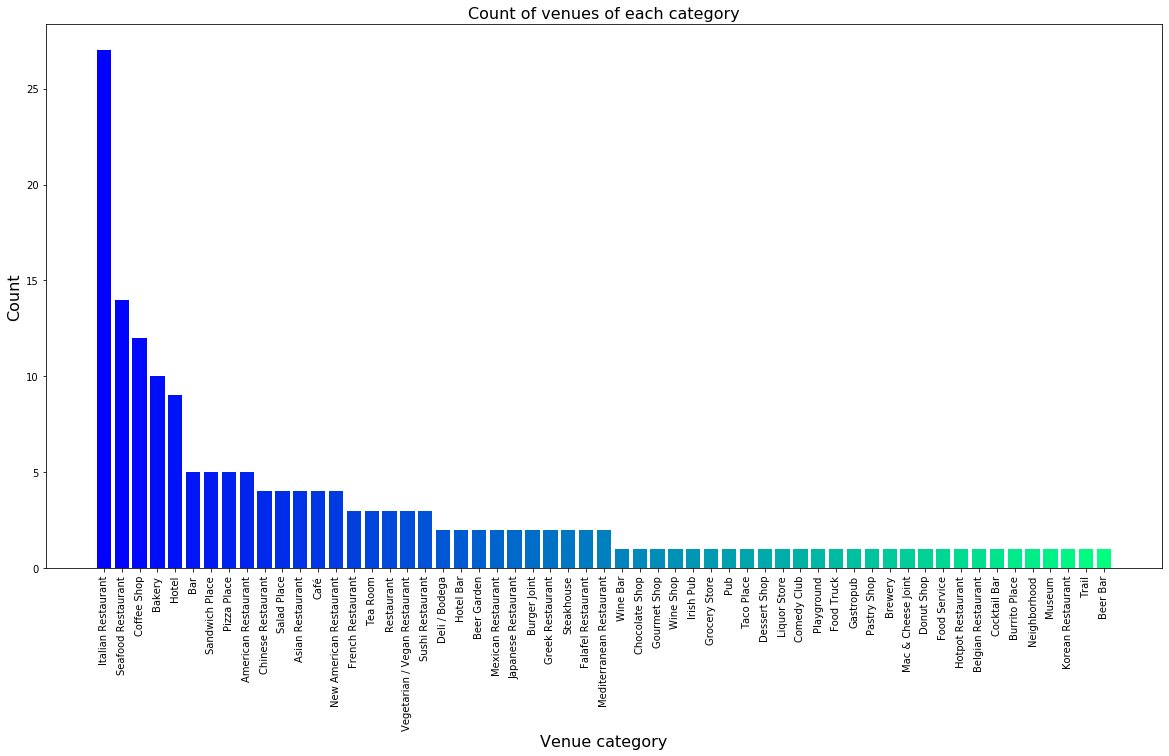

In [135]:
venue_distribution = final_df['categories'].value_counts()
colors = cm.winter(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 10))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

**Looking at the above barplot, we can see that the number of Italian Restaurants is almost double of it's closest competitor. In spite of being a costal city, Italian food dominating Seafood is an interesting thing to watch!**

## Clustering

To get better understanding, restaurants have been clustered on basis of their location and rating. This will help us group similarly rated venues with their locations.

In [286]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 3

clustering = df_cluster.drop(['name', 'id', 'categories','Likes','Tips'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
df_cluster.insert(0, 'cluster_labels', kMeans.labels_)
df_cluster

,cluster_labels,id,name,categories,lat,lng,Likes,Rating,Tips
0,0,5b05fb67f193c0002cbd9455,Trillium Garden On The Greenway,Beer Garden,42.356540,-71.051100,91,9.4,4
1,0,55098425498e04ef460a3649,Kane's Donuts,Donut Shop,42.356209,-71.052895,83,9.1,14
2,0,4a9699adf964a5205e2620e3,James Hook & Company,Seafood Restaurant,42.354960,-71.050911,324,9.1,87
3,2,4d1a255481cea35d5867faec,Casa Razdora,Italian Restaurant,42.358231,-71.054741,53,8.6,28
4,2,4a8407f5f964a520b4fb1fe3,The Langham Boston Hotel,Hotel,42.356482,-71.054501,141,8.4,52
5,2,4a79ae84f964a52054e71fe3,Boston Harbor Hotel,Hotel,42.356192,-71.050370,156,8.7,34
6,1,4bd1ddb677b29c74906f8d82,Mr. Dooley's,Pub,42.357783,-71.053553,159,8.3,60
7,1,539839c5498e6ed2a0935358,Wheelhouse,Burger Joint,42.358028,-71.053979,49,8.3,22
8,2,4bb25ed442959c7450be202c,Boston Wine Exchange,Wine Shop,42.356070,-71.057420,32,8.7,9
9,0,4f049c5d00399761c77a111b,Zo,Greek Restaurant,42.359196,-71.055467,48,8.8,21


Plotting the clusters on a map.

In [287]:
clustered_map = folium.Map(location=[latitude, longitude], zoom_start=14)
color_map = { 0: 'green', 1: 'red', 2: 'blue'}

# add venues to the map
#markers_colors = []
for cluster, name, categories, lat, lng in zip(df_cluster['cluster_labels'], 
                                                df_cluster['name'], 
                                                df_cluster['categories'], 
                                                df_cluster['lat'],
                                                df_cluster['lng']):
    label = folium.Popup(str(name), parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 4,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(clustered_map)
    
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(clustered_map)    

#chandigarh_map.save("maps/Venues Clusters.html")
clustered_map

**From the map, we can see that Cluster 2(Blue) is the most widely spread. <br>
Cluster 1(Red) is more heavy on the Eastern side of downtown with a few locations in the North as well. This looks like the biggest cluster with others clusters looking like its subset.  <br>
Cluster 0(Green) looks the weakest and has the fewest number of restaurants.**

Lets take a look at actual venues and their stats under each cluster.

In [292]:
cluster_result0 = df_cluster[df_cluster['cluster_labels'] == 0]
print("Cluster 0")
cluster_result0.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,id,name,categories,lat,lng,Likes,Rating,Tips
0,0,5b05fb67f193c0002cbd9455,Trillium Garden On The Greenway,Beer Garden,42.356540,-71.051100,91,9.4,4
1,0,55098425498e04ef460a3649,Kane's Donuts,Donut Shop,42.356209,-71.052895,83,9.1,14
2,0,4a9699adf964a5205e2620e3,James Hook & Company,Seafood Restaurant,42.354960,-71.050911,324,9.1,87
3,0,4f049c5d00399761c77a111b,Zo,Greek Restaurant,42.359196,-71.055467,48,8.8,21
4,0,577be842498e0a21aa1cc211,Clover Food Lab FIN,Vegetarian / Vegan Restaurant,42.353715,-71.056216,62,9.1,10
5,0,5c95073698fbfc002c2847c1,Tatte Bakery & Cafe,Bakery,42.358451,-71.057981,27,8.8,6
6,0,545e63ab498ed5438af2a15e,Ghirardelli,Chocolate Shop,42.360412,-71.055324,48,9.0,7
7,0,572b7990498e53c1a5b9b2d2,sweetgreen,Salad Place,42.357704,-71.058713,82,8.9,18
8,0,5c2f8ffcb25fee002b84e590,Tatte Bakery & Cafe,Bakery,42.353111,-71.057117,43,9.2,6
9,0,57fbb58e498e466c222aa37d,sweetgreen,Salad Place,42.353943,-71.058550,53,9.1,12


In [293]:
cluster_result0.describe()

,cluster_labels,lat,lng,Likes,Rating,Tips
count,40.0,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.0,42.356583,-71.054068,175.775000,8.965000,57.850000
std,0.0,0.004946,0.004852,173.291142,0.164161,74.534642
min,0.0,42.349570,-71.062807,15.000000,8.800000,0.000000
25%,0.0,42.352137,-71.057333,53.750000,8.800000,10.750000
50%,0.0,42.355937,-71.054856,100.000000,8.900000,19.500000
75%,0.0,42.360782,-71.050691,284.750000,9.100000,74.250000
max,0.0,42.365055,-71.043246,639.000000,9.400000,350.000000


**As observed, Green is infact the smallest cluster with just 40 restaurants. Their average rating is 8.9 though! This cluster has the best restaurants in the neighborood.**

In [294]:
cluster_result1 = df_cluster[df_cluster['cluster_labels'] == 1]
print("Cluster 1")
cluster_result1.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,id,name,categories,lat,lng,Likes,Rating,Tips
0,1,4bd1ddb677b29c74906f8d82,Mr. Dooley's,Pub,42.357783,-71.053553,159,8.3,60
1,1,539839c5498e6ed2a0935358,Wheelhouse,Burger Joint,42.358028,-71.053979,49,8.3,22
2,1,4ab562a2f964a520527420e3,Boston College Club,American Restaurant,42.355082,-71.055722,27,8.2,9
3,1,4eb16c0b6c25700faa4d38db,Bon Me,Food Truck,42.356875,-71.051474,103,8.1,35
4,1,5af7025083e380002cbe105d,Blue Bottle Coffee,Coffee Shop,42.355269,-71.055589,23,8.1,5
5,1,51c3a542498eb08b9e3020db,Nebo,Italian Restaurant,42.354129,-71.053295,132,8.3,38
6,1,5a317d2d123a1968dca410c3,Sweetgreen,Salad Place,42.356035,-71.054051,5,8.1,1
7,1,4ca216f746978cfa5aa1c17f,Pavia - Italian Cuisine & Catering,Italian Restaurant,42.357752,-71.055913,22,8.1,19
8,1,40b28c80f964a520c3f71ee3,Rowes Wharf Bar,Bar,42.356224,-71.050255,18,8.3,4
9,1,5be65689270ee7002c0908a0,Kamakura,Japanese Restaurant,42.359290,-71.054505,6,8.3,3


In [295]:
cluster_result1.describe()

,cluster_labels,lat,lng,Likes,Rating,Tips
count,76.0,76.000000,76.000000,76.000000,76.000000,76.000000
mean,1.0,42.357668,-71.055979,104.223684,8.180263,40.315789
std,0.0,0.004415,0.004661,114.793449,0.092405,46.156317
min,1.0,42.349541,-71.064724,5.000000,8.000000,0.000000
25%,1.0,42.354739,-71.059852,27.000000,8.100000,9.000000
50%,1.0,42.357836,-71.055372,75.000000,8.200000,26.500000
75%,1.0,42.360626,-71.053475,134.250000,8.300000,53.000000
max,1.0,42.364956,-71.045179,647.000000,8.300000,267.000000


**Cluster Red has a average rating of 8.1 which is lowest of all the clusters. Even the average tips and number of likes for these restaurants is the lowest.**

In [296]:
cluster_result2 = df_cluster[df_cluster['cluster_labels'] == 2]
print("Cluster 2")
cluster_result2.head(10).reset_index(drop = True)

Cluster 2


,cluster_labels,id,name,categories,lat,lng,Likes,Rating,Tips
0,2,4d1a255481cea35d5867faec,Casa Razdora,Italian Restaurant,42.358231,-71.054741,53,8.6,28
1,2,4a8407f5f964a520b4fb1fe3,The Langham Boston Hotel,Hotel,42.356482,-71.054501,141,8.4,52
2,2,4a79ae84f964a52054e71fe3,Boston Harbor Hotel,Hotel,42.356192,-71.050370,156,8.7,34
3,2,4bb25ed442959c7450be202c,Boston Wine Exchange,Wine Shop,42.356070,-71.057420,32,8.7,9
4,2,4abe4eaaf964a520968c20e3,Al's State Street Cafe,Sandwich Place,42.359071,-71.054804,86,8.5,62
5,2,4b91813ef964a5206cc133e3,"Marriott Vacation Club Pulse at Custom House, ...",Hotel,42.359047,-71.053560,35,8.4,20
6,2,57079c6c498e3d4a7dcfbd84,Render Coffee,Coffee Shop,42.357145,-71.057342,45,8.4,13
7,2,56e9e969498eb30b276860e2,The Ginger Man,Beer Bar,42.359400,-71.054171,70,8.4,17
8,2,5660ddb1498e4dd40ca775ce,State Street Provisions,American Restaurant,42.359507,-71.051386,107,8.6,23
9,2,555a7a8f498eb839923af583,Ogawa Coffee Boston,Coffee Shop,42.356674,-71.058109,271,8.5,78


In [297]:
cluster_result2.describe()

,cluster_labels,lat,lng,Likes,Rating,Tips
count,59.0,59.000000,59.000000,59.000000,59.000000,59.000000
mean,2.0,42.357865,-71.055296,143.983051,8.525424,50.677966
std,0.0,0.005068,0.004643,214.550813,0.104375,78.832306
min,2.0,42.350291,-71.063976,0.000000,8.400000,0.000000
25%,2.0,42.352512,-71.058476,45.000000,8.400000,17.000000
50%,2.0,42.358125,-71.054979,86.000000,8.500000,33.000000
75%,2.0,42.363142,-71.053370,147.500000,8.600000,52.500000
max,2.0,42.365194,-71.045021,1512.000000,8.700000,568.000000


**The last cluster has average rating of 8.5. The restaurants in this cluster might be the safest options to go to with good food and not too heavy on the pocket. Other thing worth noting is that most of the restaurants are a little far from Financial District as compared to other clusters. Be ready to walk for 10 or more minutes!**